In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import copy
import random
import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import torch.nn.functional as F

import matplotlib.pyplot as plt


from src.lstm_encoder_decoder import *

In [2]:
torch.__version__

'2.0.0+cu118'

# Data

Each trajectory is represented by a N x M matrix,

where N is the number of stay points, and M i number of all POIs


In [3]:
data = np.load('poi_small.npy', allow_pickle=True)
len(data), data[0].shape

(27839, (17, 6))

In [4]:
def normalize_data(xs: list[np.ndarray]) -> list[np.ndarray]:
    res = []
    for x in xs:
        res.append(normalize(x, axis=1, norm='l1'))
    return res

In [5]:
M = 6
data = data
len(data), data[0].shape

(27839, (17, 6))

In [6]:
normalized_data = normalize_data(data)

## Training

In [7]:
n_epochs = 15
batch_size = 1
learning_rate = 0.001

model = EncoderDecoder(input_size=M, hidden_size=256).cuda()

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()


In [8]:
input_batches = [
    torch.from_numpy(x).type(torch.Tensor).view(x.shape[0], batch_size, x.shape[1]).cuda()
    for x in normalized_data
]

In [9]:
len(input_batches)

27839

In [10]:
input_batches[4].shape

torch.Size([30, 1, 6])

In [11]:
losses = []
losses_per_epoch = []
best_model = None

In [12]:
model.load_state_dict(torch.load("./models/encoder_decoder_v1.pth"))

<All keys matched successfully>

In [13]:
# best_loss = 1e18
# for epoch in range(n_epochs):
#     epoch_losses = []
#     for input_batch in tqdm(input_batches):
#         # print("input_batch: ", input_batch.shape)
        
#         # initialize hidden state
#         encoder_hidden = model.encoder.init_hidden(batch_size)

#         # zero the gradient
#         optimizer.zero_grad()
        
#          # encoder outputs
#         encoder_output, encoder_hidden = model.encoder(input_batch)
#         # print("encoder_output: ", encoder_output.shape)
#         # print("encoder_hidden0: ", encoder_hidden[0].shape)
#         # print("encoder_hidden1: ", encoder_hidden[1].shape)
        
#          # outputs tensor
#         target_len = len(input_batch)
#         outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])
                
#         # decoder with teacher forcing
#         decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
#         decoder_hidden = encoder_hidden

#         for t in range(target_len): 
#             decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden)
#             decoder_input = decoder_output
#             outputs[t] = decoder_output

#         # decoder_output, decoder_hidden = model.decoder(input_batch[-1, :, :], encoder_hidden)
#         # print("outputs: ", outputs.shape)
        
#         loss = criterion(input_batch, outputs.cuda())
#         # backpropagation
#         loss.backward()
#         optimizer.step()
        
#         losses.append(loss.cpu().detach())
#         epoch_losses.append(loss.cpu().detach())

#     epoch_loss = np.mean(epoch_losses)
#     losses_per_epoch.append(epoch_loss)
#     print(f"epoch {epoch} loss {epoch_loss}")
#     if epoch_loss > best_loss:
#         break
#     else:
#         best_loss = epoch_loss


In [14]:
# plt.plot(losses_per_epoch)
# plt.show()
# plt.plot([x.numpy() for x in losses])
# plt.show()
# plt.plot([x.numpy() for x in epoch_losses])
# plt.show()

In [15]:
# torch.save(model.state_dict(), "./models/encoder_decoder_v2.pth")

## Embedding after Phase I

In [16]:
embedded_data =  [
    model.encoder(x)[1][0].detach().cpu().numpy()
    for x in input_batches
]

In [17]:
len(embedded_data), embedded_data[0].shape

(27839, (1, 1, 256))

In [18]:
embedded_data = np.vstack(embedded_data)
embedded_data = embedded_data.reshape(embedded_data.shape[0], embedded_data.shape[2])
embedded_data.shape

(27839, 256)

In [19]:
%%time
X_embedded = TSNE(
    n_components=2, learning_rate='auto',
    init='random', perplexity=30
).fit_transform(embedded_data)

CPU times: total: 13min 1s
Wall time: 1min 15s


In [20]:
X_embedded.shape

(27839, 2)

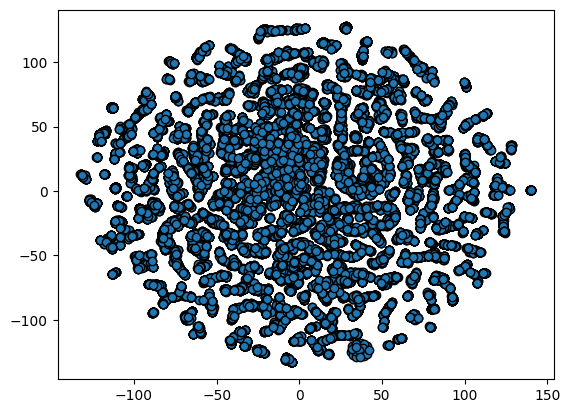

In [21]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], edgecolors="black")

## K Means

In [22]:
from sklearn.cluster import KMeans

In [23]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(embedded_data)

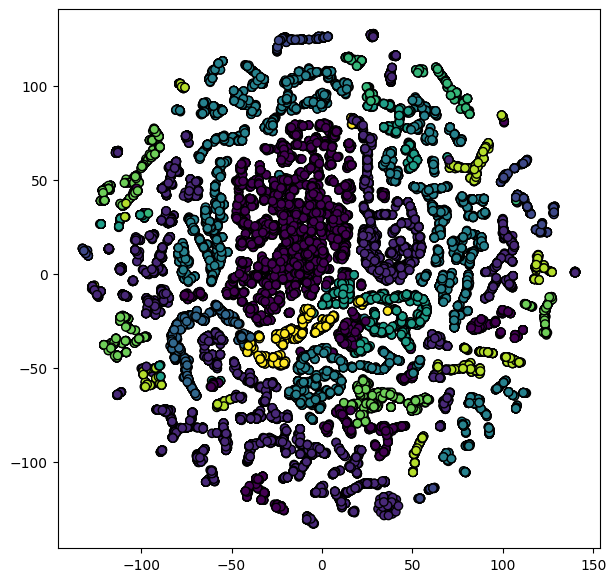

In [24]:
plt.figure(figsize=(7, 7))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], edgecolors="black", c=kmeans.labels_)

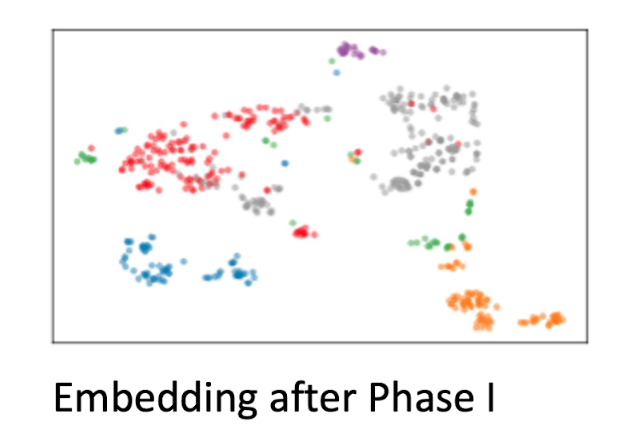


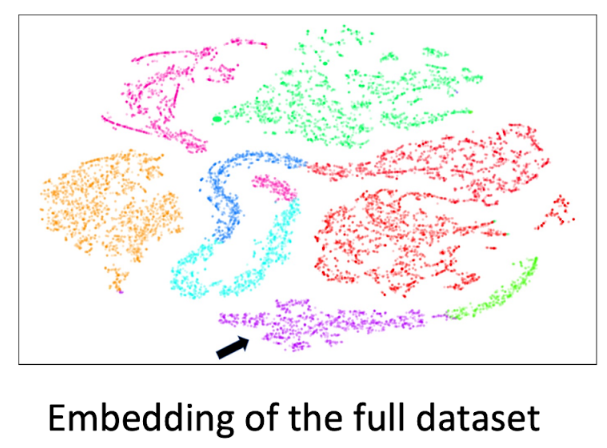

## show trajectories

In [25]:
from src.datareader import DataReader
data_reader = DataReader("VED_dataset/*.csv", files_limit=2)
trajectory_data = data_reader.get_data()

In [26]:
trajectory_data.shape, trajectory_data[0].shape

((1314,), (2104, 3))

In [27]:
X_embedded.shape

(27839, 2)

In [28]:
from src.fastspd import FastSPD
fastspd = FastSPD()
compressed_data = [fastspd.compress(row) for _, row in enumerate(trajectory_data)]
len(compressed_data)

1314

In [29]:
colors = [
    "aqua", "azure", "black", "blue", "coral", "darkblue", "darkgreen", "gold", "indigo", "ivory", "yellow", "white"
]

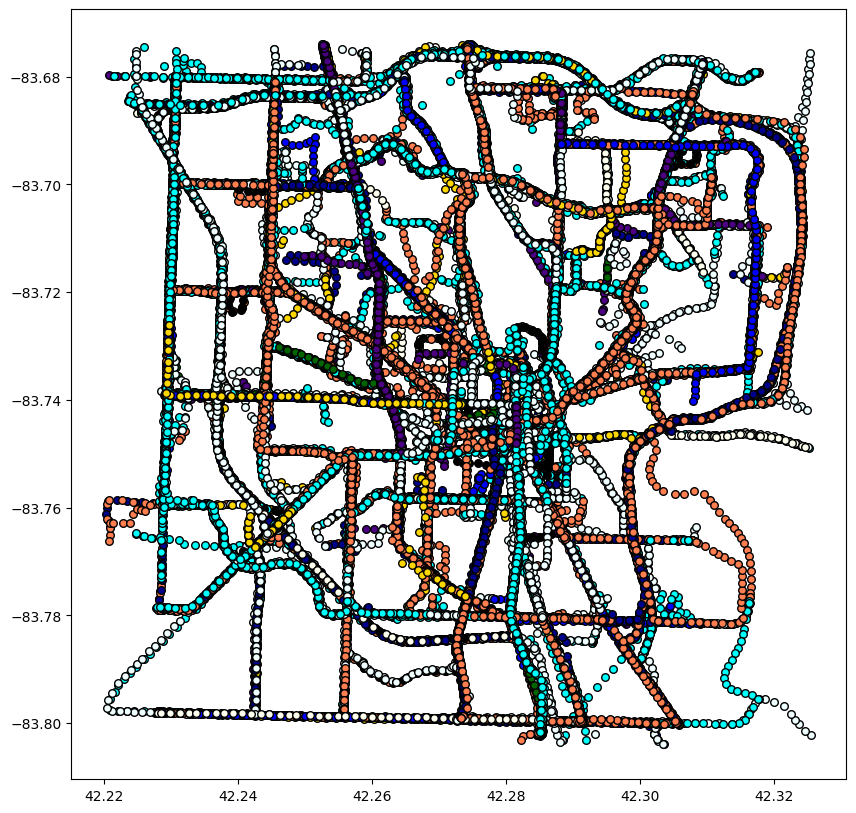

In [37]:
plt.figure(figsize=(10, 10))
for i, trajectory in enumerate(compressed_data):
    n = trajectory.shape[0]
    color = colors[kmeans.labels_[i]]
    plt.scatter(
        trajectory[:, 1],
        trajectory[:, 2],
        edgecolors="black",
        color=color,
        s=30
    )

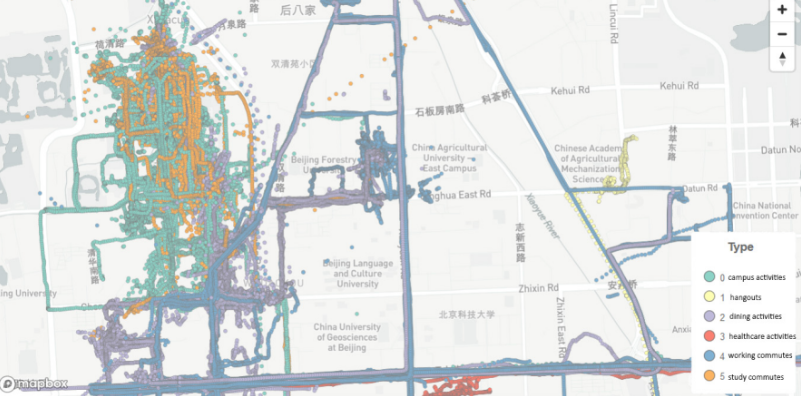